In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors
import random
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
random.seed(3108)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Data Preprocessing**

In [ ]:
rawData = pd.read_csv('gdrive/My Drive/Capstone Project/2022_LoL_esports_match_data_from_OraclesElixir_20221201.csv')
rawData.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,121.0,391.0,345.0,14.0,0.0,1.0,0.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,100.0,541.0,-275.0,-11.0,2.0,3.0,2.0,0.0,5.0,1.0
2,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,119.0,-475.0,153.0,1.0,0.0,3.0,0.0,3.0,3.0,2.0
3,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,149.0,-793.0,-1343.0,-34.0,2.0,1.0,2.0,3.0,3.0,0.0
4,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,21.0,443.0,-497.0,7.0,1.0,2.0,2.0,0.0,6.0,2.0


In [ ]:
# filter position == 'team' & datacompleteness == 'complete'
data_1 = rawData[(rawData['position'] == 'team') & (rawData['datacompleteness'] == 'complete')]
print(data_1.shape) # 21206, 123

(21206, 123)


In [ ]:
def readFile(path):
    with open(path, 'rt') as f:
        return f.read()

selectedVars_file = readFile('gdrive/My Drive/Capstone Project/selectedVars.txt')
selectedVars = list()
for varName in selectedVars_file.splitlines():
    selectedVars.append(varName)

# 95 variables selected for the analysis
data_1 = data_1[selectedVars]
print(data_1.shape) # 21206, 95

(21206, 95)


In [ ]:
# check missing values for each variable
def checkMissing(dataFrame):
    missingVars = dict()
    for var in dataFrame.columns.values:
        missingCount = dataFrame[var].isnull().sum()
        if missingCount > 0:
            missingVars[var] = missingCount
    if len(missingVars) == 0: 
        print('No missing entries in the dataframe.')
    return missingVars
checkMissing(data_1)

{'elementaldrakes': 88,
 'opp_elementaldrakes': 88,
 'chemtechs': 88,
 'hextechs': 88,
 'dragons (type unknown)': 20552,
 'firstmidtower': 4,
 'turretplates': 88,
 'opp_turretplates': 88,
 'monsterkillsownjungle': 21118,
 'monsterkillsenemyjungle': 21118}

In [ ]:
# delete 'dragons (type unknown)', 'monsterkillsownjungle', 'monsterkillsenemyjungle' due to large missing entries
data_2 = data_1.drop(['dragons (type unknown)','monsterkillsownjungle','monsterkillsenemyjungle'], axis = 1)

droppedData = data_2[(data_2['elementaldrakes'].isnull()) | (data_2['firstmidtower'].isnull())]
# check whether the data (that we plan to drop) belong to the same set of datasets
def checkSameGames(dataFrame):
    rowsWithIssues = list()
    for i in range(dataFrame.shape[0],2):
        gameLength_1 = dataFrame.iloc[i,3] # "gamelength" index = 3
        gameLength_2 = dataFrame.iloc[i+1,3]
        if gameLength_1 != gameLength_2: rowsWithIssues.append(i)
    if len(rowsWithIssues) == 0: 
        print("All dropped rows belong to the same set of games")
        return True
    else:
        return rowsWithIssues
checkSameGames(droppedData)
print(droppedData.shape)

# check whether the 88 missing entries came from the same 88 rows
# drop rows that has NaN values on 'elementaldrakes','firstmidtower'
data_2 = data_2.dropna(subset=['elementaldrakes','firstmidtower'])
checkMissing(data_2)

# reset index
data_3 = data_2.reset_index()
data_3.rename(columns = {"index": "old index"}, inplace = True)

All dropped rows belong to the same set of games
(92, 92)
No missing entries in the dataframe.


In [ ]:
data_3.shape #(21114, 93)
data_3.head()

,old index,league,patch,side,gamelength,result,kills,deaths,assists,doublekills,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,10,LCK CL,12.01,Blue,1713,0,9,19,19,0.0,...,510.0,107.0,-1617.0,-23.0,5.0,10.0,6.0,6.0,18.0,5.0
1,11,LCK CL,12.01,Red,1713,1,19,9,62,6.0,...,487.0,-107.0,1617.0,23.0,6.0,18.0,5.0,5.0,10.0,6.0
2,22,LCK CL,12.01,Blue,2114,0,3,16,7,0.0,...,555.0,-1763.0,-906.0,-22.0,1.0,1.0,3.0,3.0,3.0,1.0
3,23,LCK CL,12.01,Red,2114,1,16,3,39,1.0,...,533.0,1763.0,906.0,22.0,3.0,3.0,1.0,1.0,1.0,3.0
4,46,LCK CL,12.01,Blue,1972,1,14,5,42,3.0,...,545.0,1191.0,2298.0,15.0,3.0,8.0,1.0,1.0,1.0,3.0


In [ ]:
# identify different types of variables
allFeatures = data_3.columns.values[1:]
textVars = ['league','side','patch']
binaryVars = ['result','firstblood','firstdragon','firstherald','firstbaron','firsttower','firstmidtower','firsttothreetowers']
numericVars = [var for var in allFeatures if (var not in textVars) & (var not in binaryVars)]
textData = data_3[textVars]
binaryData = data_3[binaryVars]
numericData = data_3[numericVars]

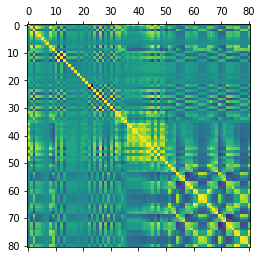

In [ ]:
# draw correlation matrix
plt.figure(figsize=(12,12))
plt.matshow(numericData.corr())
plt.show()

In [ ]:
###########DEMO##############
# Standardization: standardize features by removing the mean and scaling to unit variance.
# data_3: data_standardization 
# Transformations are best applied to the training data, with the centering and scaling values 
# retained and applied to the test data afterwards. 
# xtrain, xtest, ytrain, ytest = train_test_split(numericData, data_2['result'], test_size=0.2, random_state=3108)
# scaler = StandardScaler().fit(xtrain)
# data_3 = pd.DataFrame(scaler.transform(xtrain), columns = numericVars) 
# trainMeans = pd.DataFrame(scaler.mean_, index = numericVars, columns = ["Mean_train"]) 
# trainVars = pd.DataFrame(scaler.var_, index = numericVars, columns = ["Variance_train"]) 

## **Inference**

In [ ]:
data_infer = data_3[["patch","side","result"]]
data_infer.isna().sum() # no missing data

patch     0
side      0
result    0
dtype: int64

In [ ]:
## randomly pick one of two
def RandomPickOne(data):
    n = data.shape[0]
    index = np.arange(0,n,2)+np.random.binomial(1,0.5,n//2)
    return data.iloc[index,:]
## do Chi-square for data:
def ChiSquareTest(data):
    sub = RandomPickOne(data)
    table = pd.crosstab(sub["side"], sub["result"], margins=False)
    return chi2_contingency(table)

In [ ]:
# Global Analysis 
blue = data_infer.shape[0]//2 
bluewin = sum(data_infer[data_infer["side"]=="Blue"]["result"])
print(bluewin/blue*100)

52.27810931135739


In [ ]:
sub = RandomPickOne(data_infer)
table_all = pd.crosstab(sub["side"], sub["result"], margins=True)
table = pd.crosstab(sub["side"], sub["result"], margins=False)
table_all

result,0,1,All
side,,,
Blue,2517,2733,5250
Red,2787,2520,5307
All,5304,5253,10557


In [ ]:
# Chi-Square using the table above (same randomly-picked dataset)
chi2_contingency(table) # p-value = 3.16

(21.891475603169233,
 2.88512701565321e-06,
 1,
 array([[2637.68115942, 2612.31884058],
        [2666.31884058, 2640.68115942]]))

In [ ]:
## for each patch
patch_table = pd.DataFrame(data_3.groupby("patch").size())
patch_table.columns =["Number"]
patches = patch_table.index
pvalues = []
bluewinrate =[]
for patch in patches:
    data = data_infer[data_infer["patch"]==patch]
    blue = data.shape[0]//2 
    bluewin = sum(data[data["side"]=="Blue"]["result"])
    bluewinrate.append(bluewin/blue*100)
    v,p = ChiSquareTest(data)[0:2]
    pvalues.append(p)
patch_table["BlueWinRate"] = bluewinrate
patch_table["p-value"] = pvalues
patch_table["Number"] = patch_table["Number"]//2

In [ ]:
patch_table.iloc[:11,:]

,Number,BlueWinRate,p-value
patch,,,
12.01,697,49.641320,0.925711
12.02,719,50.486787,0.873517
12.03,870,50.689655,0.734817
12.04,897,54.515050,0.006831
12.05,1099,47.224750,0.076466
12.06,187,56.684492,0.106289
12.07,81,53.086420,0.671599
12.08,181,50.276243,1.000000
12.09,352,55.113636,0.066350


In [ ]:
### plot rate
blue_cmap = plt.cm.get_cmap('Blues_r')
red_cmap = plt.cm.get_cmap('Reds_r')
color = []
colorline = [x**0.2-0.2 for x in pvalues]
for i in range(21):
    if patch_table.iloc[i,1]<50:
        color.append(red_cmap(colorline[i]))
    else:
        color.append(blue_cmap(colorline[i]))

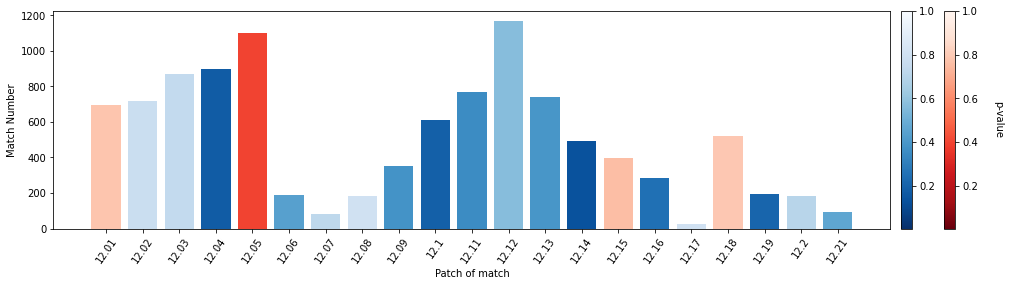

In [ ]:
from matplotlib.cm import ScalarMappable
fig, ax = plt.subplots(figsize=(15, 4))
## bar plot
bars = ax.bar(patch_table.index.astype("str"),patch_table["Number"], color=color)
#ax.bar_label(bars,["*"if x<0.05 else "" for x in patch_table["p-value"]], size="x-large")

## color bar
sm = ScalarMappable(cmap=blue_cmap, norm=plt.Normalize(min(pvalues),max(pvalues)))
sm.set_array([])
position = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.010, ax.get_position().height])
cbar = plt.colorbar(sm,cax=position)
sm = ScalarMappable(cmap=red_cmap, norm=plt.Normalize(min(pvalues),max(pvalues)))
sm.set_array([])
position = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0,0.010, ax.get_position().height])
cbar = plt.colorbar(sm,cax=position)
cbar.set_label('p-value', rotation=270,labelpad=25)

ax.tick_params(axis='x', rotation=55)
ax.set_xlabel("Patch of match")
ax.set_ylabel("Match Number")

plt.show()

## **Prediction**

#### Varible Select

In [ ]:
goldVars = ['totalgold','earnedgold','earned gpm','goldspent','gspd','goldat10','opp_goldat10','golddiffat10','goldat15','opp_goldat15','golddiffat15']
varsForPred = [var for var in allFeatures if (var not in textVars) & (var not in goldVars) & (var != 'result')]

# train test split
xtrain, xtest, ytrain, ytest = train_test_split(data_3[varsForPred], data_3['totalgold'],test_size=0.2, random_state=3108)

In [ ]:
# Standardization: for numeric training data 
# Select numeric vars to be standardized
varsForPred_numeric = [var for var in varsForPred if var not in binaryVars]
varsForPred_binary = [var for var in binaryVars if var != 'result']

# standard scaler_fit to training data
scaler = StandardScaler().fit(xtrain[varsForPred_numeric])

In [ ]:
# generate standardized numeric datasets for xtrain & xtest
stdTrain_numeric = pd.DataFrame(scaler.transform(xtrain[varsForPred_numeric]), columns = varsForPred_numeric,index = xtrain.index) 
stdTest_numeric = pd.DataFrame(scaler.transform(xtest[varsForPred_numeric]), columns = varsForPred_numeric,index = xtest.index)  

# combine numberic data with binary data (xtrain & xtest)
xtrain_std_all = pd.concat([stdTrain_numeric,xtrain[varsForPred_binary]],axis=1)
xtest_std_all = pd.concat([stdTest_numeric,xtest[varsForPred_binary]],axis=1)

#### Regression/Prediction

In [ ]:
pipeline = Pipeline([
                     ('model',Lasso())
])
     

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(300,450,10)}, # has to set to 300 to achieve feature selection (num of Vars =< 11)
                      cv = 5, 
                      scoring={"R2": 'r2', "mse": 'neg_root_mean_squared_error'},
                      refit='R2',
                      verbose=3
                      )

In [ ]:
search.fit(xtrain_std_all, ytrain)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END model__alpha=300; R2: (test=0.985) mse: (test=-1395.364) total time=   0.1s
[CV 2/5] END model__alpha=300; R2: (test=0.985) mse: (test=-1379.301) total time=   0.1s
[CV 3/5] END model__alpha=300; R2: (test=0.985) mse: (test=-1400.921) total time=   0.1s
[CV 4/5] END model__alpha=300; R2: (test=0.985) mse: (test=-1410.935) total time=   0.1s
[CV 5/5] END model__alpha=300; R2: (test=0.985) mse: (test=-1408.138) total time=   0.1s
[CV 1/5] END model__alpha=310; R2: (test=0.984) mse: (test=-1402.085) total time=   0.1s
[CV 2/5] END model__alpha=310; R2: (test=0.985) mse: (test=-1386.423) total time=   0.1s
[CV 3/5] END model__alpha=310; R2: (test=0.985) mse: (test=-1408.159) total time=   0.1s
[CV 4/5] END model__alpha=310; R2: (test=0.985) mse: (test=-1418.413) total time=   0.1s
[CV 5/5] END model__alpha=310; R2: (test=0.985) mse: (test=-1415.577) total time=   0.2s
[CV 1/5] END model__alpha=320; R2: (test=0.984) m

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440])},
             refit='R2',
             scoring={'R2': 'r2', 'mse': 'neg_root_mean_squared_error'},
             verbose=3)

In [ ]:
search.best_params_

{'model__alpha': 300}

In [ ]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

In [ ]:
features = xtrain_std_all.columns
important_features_idx = np.where(importance > 0)[0]
res = {features[i]: coefficients[i] for i in np.array(important_features_idx)}
res

{'gamelength': 5128.926063021533,
 'kills': 2621.1279888326703,
 'assists': 63.86484865884456,
 'elders': 84.36344984102907,
 'barons': 786.0405668117145,
 'towers': 1870.8467891098112,
 'turretplates': 27.637843485853253,
 'damagetochampions': 592.6211872860522,
 'visionscore': 210.9220621381417,
 'minionkills': 2001.172417372691,
 'monsterkills': 1188.5996231257836}

In [ ]:
#plt.matshow(xtrain_std_all[features[important_features_idx]].corr())
#plt.show()

In [ ]:
def corr_heatmap(df, digits=3, cmap='coolwarm'):
    """
    Creates a correlation heatmap to easily visualize multicollinearity
    that might be present in the dataframe.

    Args:
        df (DataFrame) : DataFrame with features to check multicollinearity on.
        digits (int) : Number of decimal places to display
        cmap (str) : Colormap to display correlation range.

    Returns:
        fig : Matplotlib Figure
        ax : Matplotlib Axis
    """
    # Create correlation matrix from dataframe
    correl = df.corr().round(digits)
    correl

    # Create mask for upper triangle of matrix
    mask = np.zeros_like(correl)
    mask[np.triu_indices_from(mask)] = True

    #Create heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df.columns)),(len(df.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,\
                mask=mask);
    return fig, ax

(<Figure size 792x792 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99bfaa8850>)

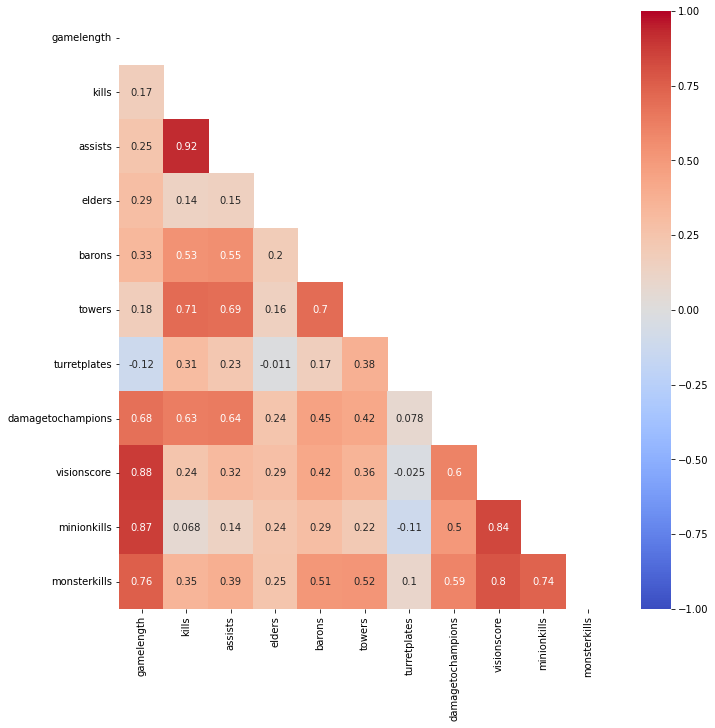

In [ ]:
corr_heatmap(xtrain_std_all[features[important_features_idx]])

In [ ]:
# delete gamelength
#xtrain_std_no_gamelength = xtrain_std_all[[var for var in xtrain_std_all.columns if var != "gamelength"]]
#search.fit(xtrain_std_no_gamelength, ytrain)
#print(search.best_params_)
#coefficients = search.best_estimator_.named_steps['model'].coef_
#importance = np.abs(coefficients)
#features_no_gamelength = [var for var in xtrain_std_all.columns if var != "gamelength"]
#important_features_idx = np.where(importance > 0)[0]
#res = {features_no_gamelength[i]: coefficients[i] for i in np.array(important_features_idx)}
#print(res)

#### PCA

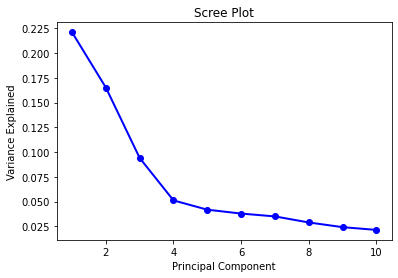

In [ ]:
#select components
#fit PCA model to data
pca = PCA(n_components=10)
pca_fit = pca.fit(stdTrain_numeric)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
#define PCA model to use
pca = PCA(n_components=4)
#fit PCA model to data
pca.fit(stdTrain_numeric)

PCA(n_components=4)

In [ ]:
pcaTrain_numeric=pd.DataFrame(pca.transform(stdTrain_numeric),index = xtrain.index)
pcaTest_numeric=pd.DataFrame(pca.transform(stdTest_numeric),index = xtest.index)
xtrain_pca_all=pd.concat([pcaTrain_numeric,xtrain[varsForPred_binary]],axis=1)
xtest_pca_all=pd.concat([pcaTest_numeric,xtest[varsForPred_binary]],axis=1)

In [ ]:
#loading
loadings = pd.DataFrame(pca.components_.T, index=stdTrain_numeric.columns) 

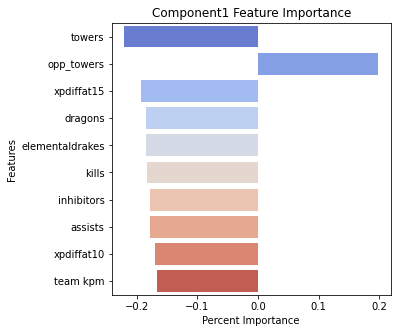

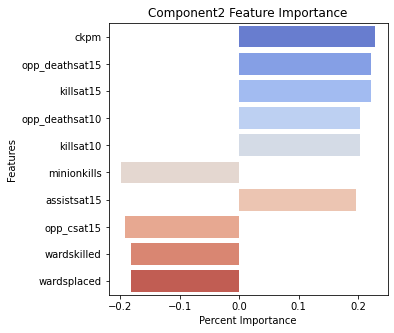

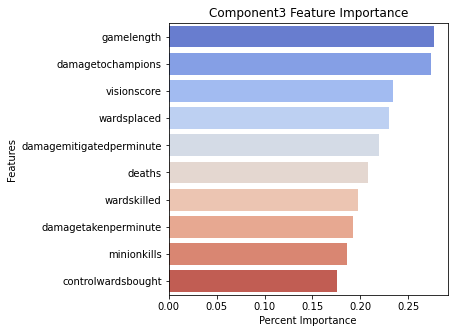

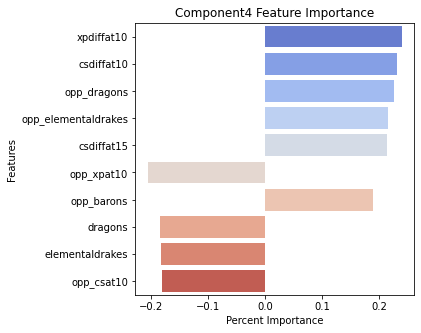

In [ ]:
def drawLoadings(componentIndex, loadingsMatrix):
    feature_idx = abs(loadingsMatrix[componentIndex]).sort_values(ascending=False).index[:10]
    feature_importance = loadingsMatrix[componentIndex][feature_idx].values
    # Create bar plot of feature importances to components 
    fig, ax = plt.subplots(figsize=(5,5))

    sns.barplot(x=feature_importance, y=feature_idx, palette='coolwarm', ax=ax, orient='h')

    ax.set_title(f'Component{componentIndex + 1} Feature Importance')
    ax.set_xlabel('Percent Importance')
    ax.set_ylabel('Features')
    return True
for componentIndex in np.arange(pca.n_components_):
    drawLoadings(componentIndex, loadings)

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

In [ ]:
# Visualize 3 principal components
fig = px.scatter_3d(pcaTrain_numeric[[0,1,2]], x=0, y=1, z=2, height=500, width=1000)
fig.update_layout(showlegend=False,
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                    center=dict(x=0, y=0, z=-0.1),
                                    eye=dict(x=1.5, y=-1.4, z=0.5)),
                  margin=dict(l=0, r=0, b=0, t=0),
                  scene=dict(xaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10)),
                             yaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10)),
                             zaxis=dict(backgroundcolor='lightgrey',
                                        color='black', 
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10))))
fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))

pac_transformed_data_mean = pcaTrain_numeric[[0,1,2]].mean(axis=0)
for length, vector in zip(pca.explained_variance_[:3], pca.components_[:3]):
    v = vector * 3 * np.sqrt(length)
    #draw_vector(pca.mean_, pca.mean_ + v)

fig.show()

#### Regression after PCA

In [ ]:
# Linear Regression
reg = LinearRegression().fit(xtrain_pca_all, ytrain)
ypred=reg.predict(xtest_pca_all)
print('r2:',r2_score(ytest,ypred))
print('mse:',mean_squared_error(ytest,ypred))


r2: 0.908343668844938
mse: 11621387.82257442


In [ ]:
pd.DataFrame(reg.coef_,index=xtrain_pca_all.columns,columns=['coef']).T

,0,1,2,3,firstblood,firstdragon,firstherald,firstbaron,firsttower,firstmidtower,firsttothreetowers
coef,-1769.082692,-1073.193486,2776.020253,-5.568835,58.431059,-988.00088,123.197089,1439.37617,197.252656,-123.405734,159.441445


In [ ]:
# Lasso Regression with GridSearch
pipeline = Pipeline([
                     ('model',Lasso())
])
     

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(300,450,10)},
                      cv = 5, 
                      scoring={"R2": 'r2', "mse": 'neg_root_mean_squared_error'},
                      refit='R2',
                      verbose=3
                      )

search.fit(xtrain_pca_all, ytrain)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END model__alpha=300; R2: (test=0.901) mse: (test=-3524.561) total time=   0.0s
[CV 2/5] END model__alpha=300; R2: (test=0.906) mse: (test=-3450.093) total time=   0.0s
[CV 3/5] END model__alpha=300; R2: (test=0.904) mse: (test=-3549.376) total time=   0.1s
[CV 4/5] END model__alpha=300; R2: (test=0.910) mse: (test=-3497.252) total time=   0.1s
[CV 5/5] END model__alpha=300; R2: (test=0.907) mse: (test=-3489.766) total time=   0.1s
[CV 1/5] END model__alpha=310; R2: (test=0.901) mse: (test=-3524.724) total time=   0.1s
[CV 2/5] END model__alpha=310; R2: (test=0.906) mse: (test=-3450.347) total time=   0.1s
[CV 3/5] END model__alpha=310; R2: (test=0.904) mse: (test=-3549.657) total time=   0.1s
[CV 4/5] END model__alpha=310; R2: (test=0.910) mse: (test=-3497.635) total time=   0.1s
[CV 5/5] END model__alpha=310; R2: (test=0.907) mse: (test=-3490.009) total time=   0.1s
[CV 1/5] END model__alpha=320; R2: (test=0.901) m

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440])},
             refit='R2',
             scoring={'R2': 'r2', 'mse': 'neg_root_mean_squared_error'},
             verbose=3)

In [ ]:
search.best_params_

{'model__alpha': 300}

In [ ]:
coefficients = search.best_estimator_.named_steps['model'].coef_
r2 = search.best_score_
importance = np.abs(coefficients)
print(r2)

0.9055040803816434


In [ ]:
features = xtrain_pca_all.columns
important_features_idx = np.where(importance > 0)[0]
res = {features[i]: coefficients[i] for i in np.array(important_features_idx)}
res

{0: -1857.201334487448, 1: -1033.1201508937513, 2: 2716.836158604074}

In [ ]:
ypred=search.best_estimator_.predict(xtest_pca_all)
print('r2:',r2_score(ytest,ypred))
print('mse:',mean_squared_error(ytest,ypred))

r2: 0.9049690255116045
mse: 12049269.218712617


## **Classification**

#### Logistic Regression

In [ ]:
data_4 = RandomPickOne(data_3)

# create new colormap
colorlist=[blue_cmap(0.1),"white",red_cmap(0.5)]
newcmap = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=1000)

In [ ]:
def runLogisticReg(dataFrame):
    predVars_final = [var for var in binaryVars+numericVars if var != "result"]
    # if only the last 30 predictors
    # predVars_final = numericVars[-30:]
    x = data_4[predVars_final]
    y = data_4["result"]
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=3108)
    lg = LogisticRegressionCV() 
    logisModel = lg.fit(xtrain, ytrain)
    weight = logisModel.coef_[0]
    weightsWithLabel = pd.Series(weight, index = predVars_final)
    importance = abs(weight)
    importanceWithLabel_sorted = pd.Series(importance, index = predVars_final).sort_values(ascending = False)
    weightsWithLabel_sorted = weightsWithLabel[importanceWithLabel_sorted[:10].index]

    # accuracy & AUC
    ypred = logisModel.predict(xtest)
    accuracy = accuracy_score(ypred, ytest)
    probs = logisModel.predict_proba(xtest)[:,1]
    precision, recall, thresholds = precision_recall_curve(ytest, probs)
    fpr, tpr, thresholds = roc_curve(ytest, probs)
    AreaUnderPR = auc(recall, precision)
    AreaUnderROC = auc(fpr, tpr)

    # Confusion_Matrix & ROC curve
    fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout = True,figsize = (10, 5))
    axes[0].plot(fpr, tpr, color=plt.cm.coolwarm(0))
    xx=np.linspace(0, 1, 100)
    axes[0].plot(xx, xx, color=plt.cm.coolwarm_r(0), linestyle = '--')
    axes[0].set_xlabel("FPR")
    axes[0].set_ylabel("TPR")
    axes[0].set_title("Auc ={}".format(auc(fpr, tpr)))
    con = ConfusionMatrixDisplay(confusion_matrix(ytest, ypred), display_labels = logisModel.classes_)
    con.plot(cmap=newcmap,ax=axes[1]) 
    
    print(f'weight: {weightsWithLabel_sorted}, accuracy: {accuracy}, AreaUnderPR: {AreaUnderPR}, AreaUnderROC: {AreaUnderROC}')
    return weightsWithLabel_sorted, accuracy, AreaUnderPR, AreaUnderROC

weight: csdiffat15      0.000600
csdiffat10      0.000544
opp_csat15     -0.000485
opp_csat10     -0.000392
golddiffat15    0.000264
xpdiffat15      0.000154
csat10          0.000151
opp_goldat15   -0.000137
goldat15        0.000128
csat15          0.000115
dtype: float64, accuracy: 0.7462121212121212, AreaUnderPR: 0.8271750994274192, AreaUnderROC: 0.8202630362695696


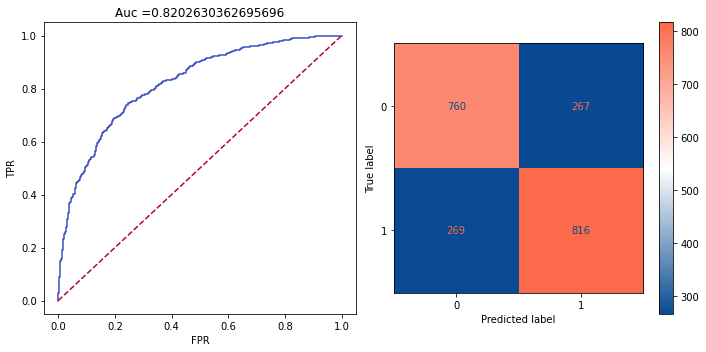

In [ ]:
weightsWithLabel_sorted, accuracy, AreaUnderPR, AreaUnderROC = runLogisticReg(data_4)

#### Random Forest

In [ ]:
varsForClas = [var for var in allFeatures if (var not in textVars)  & (var != 'result')]
xtrain, xtest, ytrain, ytest = train_test_split(data_4[varsForClas], data_4['result'],test_size=0.2, random_state=3108)
# Select numeric vars to be standardized
varsForClas_numeric = [var for var in varsForClas if var not in binaryVars] #81
varsForClas_binary = [var for var in binaryVars if var != 'result'] #7

# standard scaler_fit to training data
scaler = StandardScaler().fit(xtrain[varsForClas_numeric])
# generate standardized numeric datasets for xtrain & xtest
stdTrain_numeric = pd.DataFrame(scaler.transform(xtrain[varsForClas_numeric]), columns = varsForClas_numeric,index = xtrain.index) 
stdTest_numeric = pd.DataFrame(scaler.transform(xtest[varsForClas_numeric]), columns = varsForClas_numeric,index = xtest.index)  

# combine numberic data with binary data (xtrain & xtest)
xtrain_std_all = pd.concat([stdTrain_numeric,xtrain[varsForClas_binary]],axis=1)
xtest_std_all = pd.concat([stdTest_numeric,xtest[varsForClas_binary]],axis=1)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 4)]
max_features = [round(x,2) for x in np.linspace(start = 0.2, stop = 1.0, num = 4)]
max_depth = [round(x,2) for x in np.linspace(start = 2, stop = 10, num = 4)]
min_samples_leaf = [int(x) for x in np.linspace(start = 100, stop = 600, num = 5)]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

random_forest=RandomForestClassifier()
rf_grid = RandomizedSearchCV(estimator = random_forest,param_distributions = param_grid, 
                             n_iter = 50, random_state= 3108,scoring="accuracy")
rf_grid.fit(xtrain_std_all, ytrain)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2.0, 4.67, 7.33, 10.0],
                                        'max_features': [0.2, 0.47, 0.73, 1.0],
                                        'min_samples_leaf': [100, 225, 350, 475,
                                                             600],
                                        'n_estimators': [5, 10, 15, 20]},
                   random_state=3108, scoring='accuracy')

In [ ]:
rf_grid.best_params_

{'n_estimators': 20,
 'min_samples_leaf': 100,
 'max_features': 0.2,
 'max_depth': 4.67,
 'bootstrap': True}

In [ ]:
rf_grid.best_score_

0.9821195973949083

In [ ]:
## print importance of feature
rf_model = RandomForestClassifier(n_estimators=20,max_features=0.47,max_depth=7.33,bootstrap=False,min_samples_leaf=100)
rf_model.fit(xtrain_std_all, ytrain)
importance = pd.DataFrame(list(zip(xtrain_std_all.columns,rf_model.feature_importances_)),
                          columns=["Feature","Importance"])  
importance.sort_values(["Importance"],ascending=False).head(10)

,Feature,Importance
26,towers,0.389519
30,inhibitors,0.323722
27,opp_towers,0.160344
31,opp_inhibitors,0.098530
45,earned gpm,0.019952
2,deaths,0.002486
10,dragons,0.001269
13,opp_elementaldrakes,0.001167
3,assists,0.001114
8,team kpm,0.000385


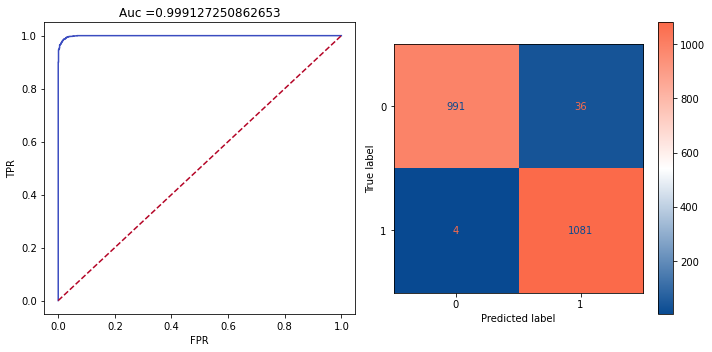

In [ ]:
yhat = rf_grid.predict(xtest_std_all)
probs = rf_model.predict_proba(xtest_std_all)[:,1]
precision, recall, thresholds = precision_recall_curve(ytest, probs)
fpr, tpr, thresholds = roc_curve(ytest, probs)

fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout = True,figsize = (10, 5))
axes[0].plot(fpr, tpr, color=plt.cm.coolwarm(0))
xx=np.linspace(0, 1, 100)
axes[0].plot(xx, xx, color=plt.cm.coolwarm_r(0), linestyle = '--')
axes[0].set_title("Auc ={}".format(auc(fpr, tpr)))
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
con = ConfusionMatrixDisplay(confusion_matrix(ytest, yhat), display_labels = rf_model.classes_)
con.plot(cmap=newcmap,ax=axes[1]) 

In [ ]:
accuracy_score(ytest,yhat)

0.9810606060606061

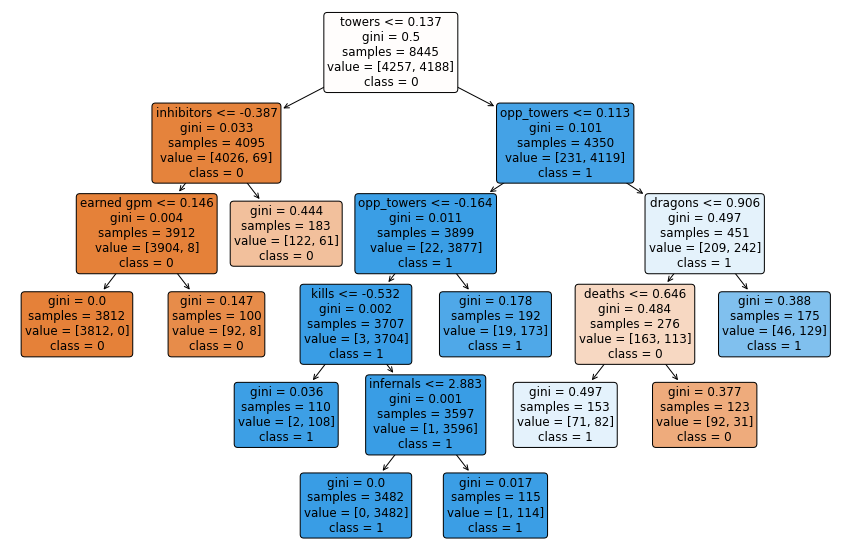

In [ ]:
fig = plt.figure(figsize=(15, 10))
plot_tree(rf_model.estimators_[0], 
          feature_names=xtrain_std_all.columns,
          class_names=np.array(["0","1"]), 
          filled=True, impurity=True, 
          rounded=True)
plt.show()

# Extra Credit

In [ ]:
LCK_kills = data_3[data_3['league'] == 'LCK']['kills']
LCS_kills = data_3[data_3['league'] == 'LCS']['kills']

In [ ]:
stats.ttest_ind(LCK_kills, LCS_kills, equal_var = False)

Ttest_indResult(statistic=-1.281970842837112, pvalue=0.20008605432632381)